In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
os.chdir('/content/drive/My Drive')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook
import time
import math
import datetime
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import KFold,train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_auc_score,roc_curve,confusion_matrix,auc
import xgboost as xgb
#import lightgbm as lgb

In [3]:
train_identity=pd.read_csv('/workspaces/Real-Time-Fraud-Detection/data/train_identity.csv')
train_transaction=pd.read_csv('/workspaces/Real-Time-Fraud-Detection/data/train_transaction.csv')

In [4]:
train_identity.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [5]:
train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
df_train=train_transaction.merge(train_identity,on=['TransactionID'],how='left')

In [7]:
df_train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [8]:
df_train.shape

(590540, 434)

In [9]:
def top_missing_cols(df,n=10,thresh=90):
  df_missing=(df.isnull().sum()/df.shape[0])*100
  df_missing=df_missing.reset_index()
  df_missing.columns=['col','missing_percent']
  df_missing=df_missing.sort_values(by=['missing_percent'],ascending=False).reset_index(drop=True)
  print(f"there are {df.isnull().any().sum()} columns in dataset with missing values")
  return df_missing[df_missing['missing_percent'] > thresh]


In [10]:
top_missing_cols(df_train,thresh=90)

there are 414 columns in dataset with missing values


,col,missing_percent
0,id_24,99.196159
1,id_25,99.130965
2,id_07,99.127070
3,id_08,99.127070
4,id_21,99.126393
5,id_26,99.125715
6,id_27,99.124699
7,id_23,99.124699
8,id_22,99.124699
9,dist2,93.628374


In [11]:
#drop columns with more than 90% missing value
df_train=df_train.drop(top_missing_cols(df_train,thresh=90)['col'],axis=1)

there are 414 columns in dataset with missing values


visualize categorical columns

In [12]:
#list of categorical cols
categorical_cols=list(df_train.select_dtypes(include=['object']).columns)
categorical_cols

['ProductCD',
 'card4',
 'card6',
 'P_emaildomain',
 'R_emaildomain',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9',
 'id_12',
 'id_15',
 'id_16',
 'id_28',
 'id_29',
 'id_30',
 'id_31',
 'id_33',
 'id_34',
 'id_35',
 'id_36',
 'id_37',
 'id_38',
 'DeviceType',
 'DeviceInfo']

In [18]:
df_train[['card4','card6','DeviceType','DeviceInfo','id_12', 'id_15', 'id_16', 'id_28', 'id_29', 'id_30', 'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']].describe(include='all')

,card4,card6,DeviceType,DeviceInfo,id_12,id_15,id_16,id_28,id_29,id_30,id_31,id_33,id_34,id_35,id_36,id_37,id_38
count,588963,588969,140810,118666,144233,140985,129340,140978,140978,77565,140282,73289,77805,140985,140985,140985,140985
unique,4,4,2,1786,2,3,2,2,2,75,130,260,4,2,2,2,2
top,visa,debit,desktop,Windows,NotFound,Found,Found,Found,Found,Windows 10,chrome 63.0,1920x1080,match_status:2,T,F,T,F
freq,384767,439938,85165,47722,123025,67728,66324,76232,74926,21155,22000,16874,60011,77814,134066,110452,73922


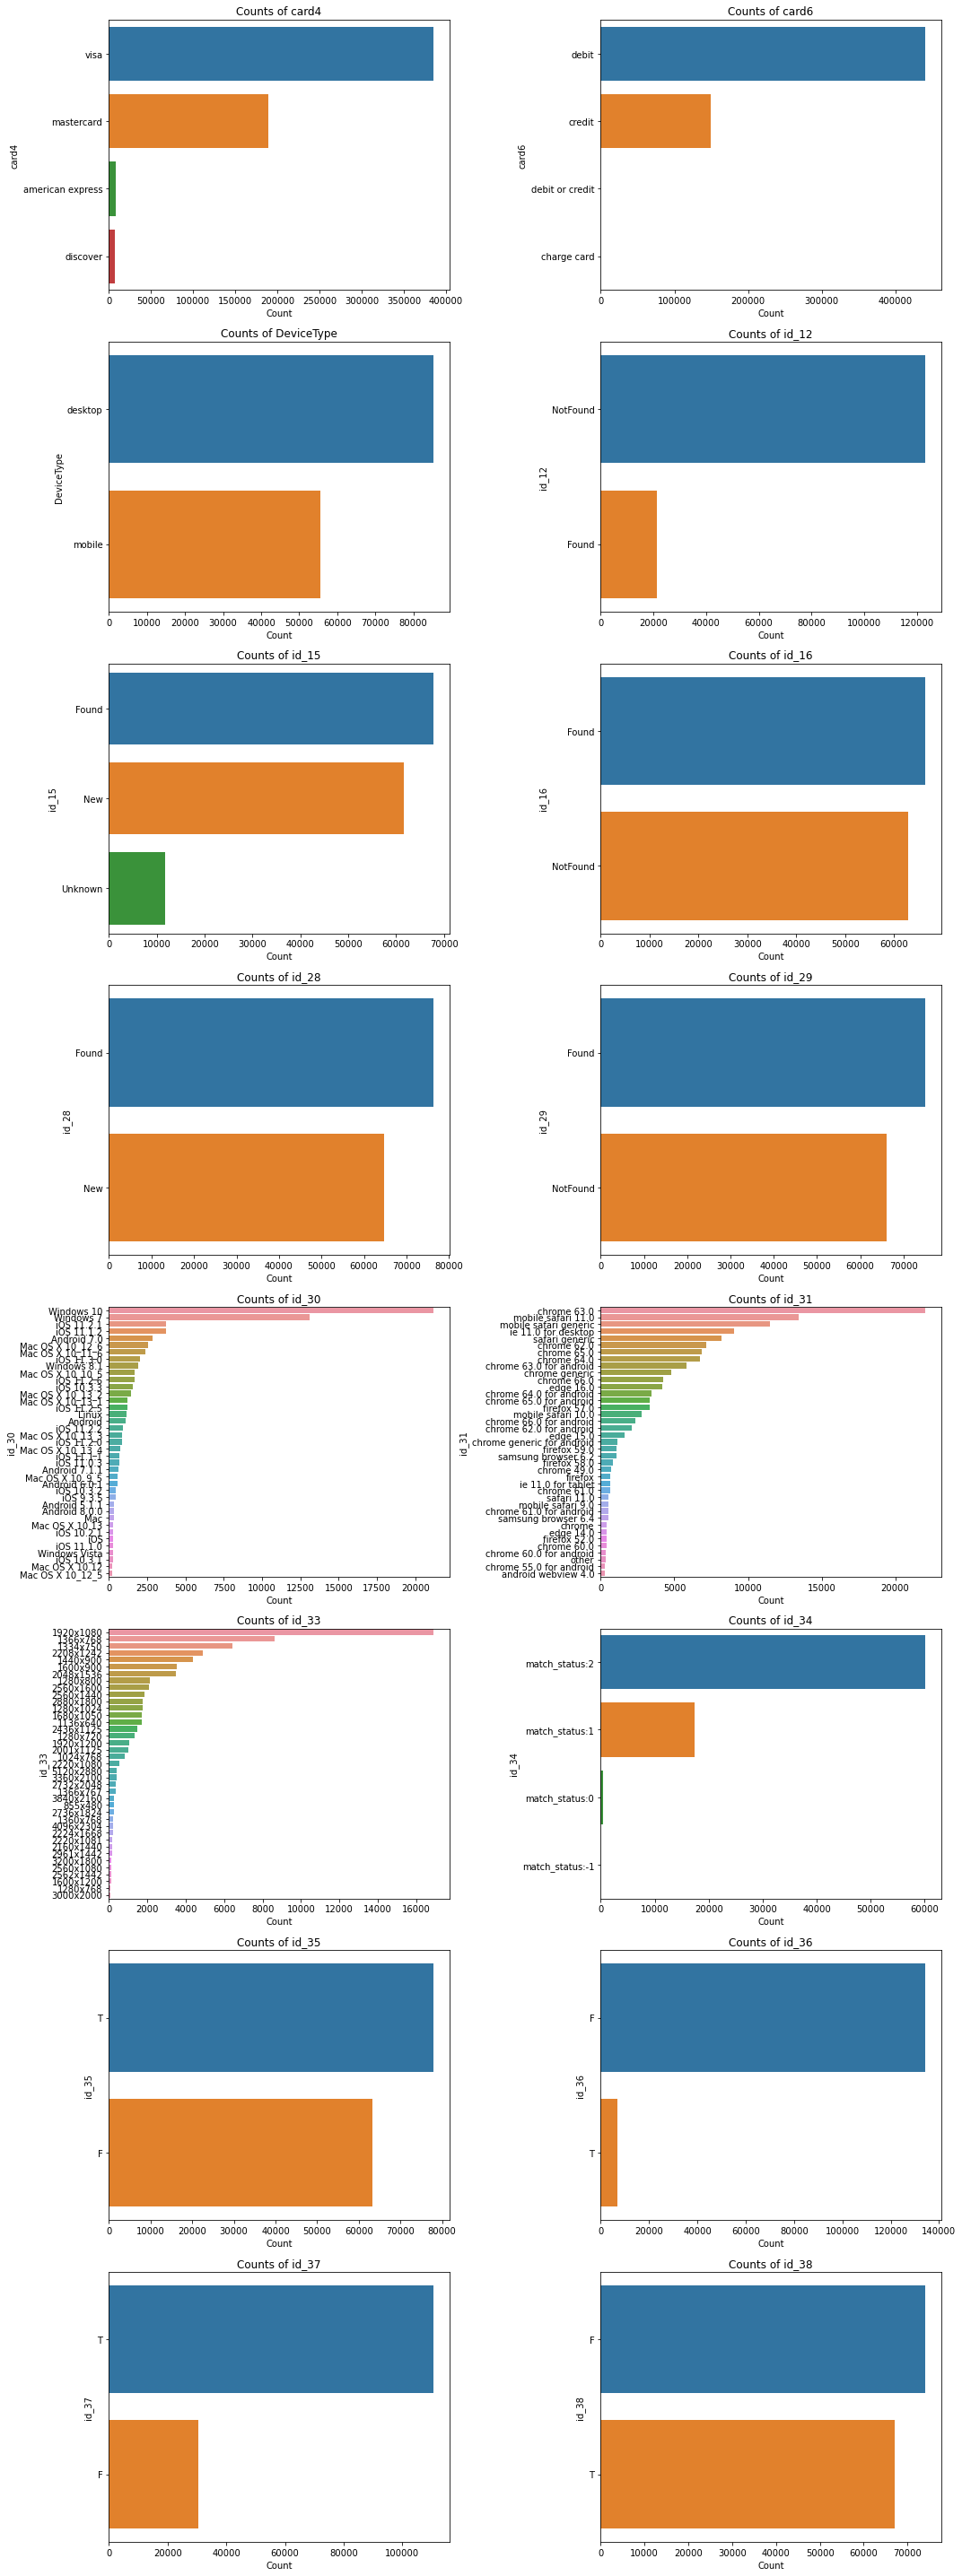

In [19]:
info = ['card4','card6','DeviceType','id_12', 'id_15', 'id_16', 'id_28', 'id_29', 'id_30', 'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']
wide_features = [ 'id_30', 'id_31', 'id_33']

# Compute the number of rows needed (2 plots per row)
num_cols = len(info)
ncols = 2
nrows = math.ceil(num_cols / ncols)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows * 5))
axes = axes.flatten()

for idx, col in enumerate(info):
    ax = axes[idx]
    vc = df_train[col].value_counts(dropna=False)

    if col in wide_features:
        vc = vc[:40]

    sns.barplot(x=vc.values, y=vc.index, ax=ax, orient='h')
    ax.set_title(f"Counts of {col}")
    ax.set_xlabel('Count')
    ax.set_ylabel(col)

# Remove any unused axes
for i in range(len(info), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

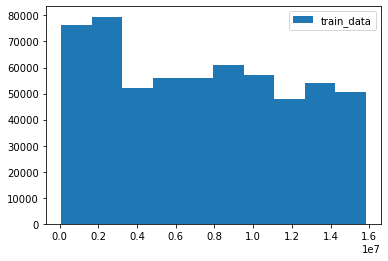

In [20]:
plt.hist(df_train['TransactionDT'],label='train_data')
plt.legend()
plt.show()

In [21]:
df_train['id_01'].value_counts(dropna=False,normalize=True).head()

 NaN     0.755761
-5.0     0.139144
 0.0     0.033114
-10.0    0.019062
-20.0    0.018984
Name: id_01, dtype: float64

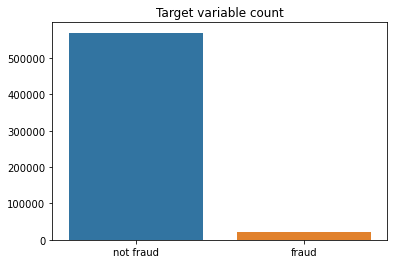

In [22]:
#target variable-class imbalance
x=df_train['isFraud'].value_counts().values
sns.barplot(x=['not fraud','fraud'],y=x)
plt.title('Target variable count')
plt.show()

In [13]:
df_train['TransactionAmt']= np.log(df_train['TransactionAmt'])

In [14]:
START_DATE='2017-12-01'
startdate=datetime.datetime.strptime(START_DATE,"%Y-%m-%d")
df_train["Date"]=df_train['TransactionDT'].apply(lambda x:(startdate + datetime.timedelta(seconds=x)))
df_train['weekdays']=df_train['Date'].dt.dayofweek
df_train['Hour']=df_train['Date'].dt.hour
df_train['Day']=df_train['Date'].dt.day

In [15]:
drop_col=['TransactionDT']
df_train.drop(drop_col,axis=1,inplace=True)

In [16]:
df_train.head()

,TransactionID,isFraud,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,Date,weekdays,Hour,Day
0,2987000,0,4.226834,W,13926,NaN,150.0,discover,142.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,2017-12-02 00:00:00,5,0,2
1,2987001,0,3.367296,W,2755,404.0,150.0,mastercard,102.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,2017-12-02 00:00:01,5,0,2
2,2987002,0,4.077537,W,4663,490.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,2017-12-02 00:01:09,5,0,2
3,2987003,0,3.912023,W,18132,567.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,2017-12-02 00:01:39,5,0,2
4,2987004,0,3.912023,H,4497,514.0,150.0,mastercard,102.0,credit,...,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M,2017-12-02 00:01:46,5,0,2


In [18]:
df_preprocess=df_train.copy()    

In [ ]:
for col in df_preprocess.columns:
    if df_preprocess[col].dtype == 'object':
        # Fill na
        df_preprocess[col] = df_preprocess[col].fillna('Unknown')
        #encode categorical values
        le = LabelEncoder()
        df_preprocess[col] = le.fit_transform(df_preprocess[col].astype(str))

In [ ]:
df_preprocess.head()